In [ ]:
!nvidia-smi

Sun Mar  5 11:13:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/tabnet/

/content/drive/MyDrive/Colab Notebooks/tabnet


In [ ]:
!pip install wget

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = f"0"

In [ ]:
import torch
torch.__version__

'1.13.1+cu116'

# Download census-income dataset

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [ ]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [ ]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [ ]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [ ]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Grouped features

You can now specify groups of feature which will share a common attention.

This may be very usefull for features comming from a same preprocessing technique like PCA for example.

In [ ]:
len(features)

14

In [ ]:
grouped_features = [[0, 1, 2], [8, 9, 10]]

# Network parameters

In [ ]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax"
                 "grouped_features" : grouped_features,
                 "device_name": "cuda:0"

                }

clf = TabNetClassifier(**tabnet_params
                      )

/content/drive/MyDrive/Colab Notebooks/tabnet/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cuda:0
  warnings.warn(f"Device used : {self.device}")


# Training

In [ ]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.5892  | train_auc: 0.80731 | valid_auc: 0.79703 |  0:00:05s
epoch 1  | loss: 0.48449 | train_auc: 0.86412 | valid_auc: 0.86835 |  0:00:07s
epoch 2  | loss: 0.44796 | train_auc: 0.88062 | valid_auc: 0.88542 |  0:00:09s
epoch 3  | loss: 0.4313  | train_auc: 0.89512 | valid_auc: 0.89786 |  0:00:10s
epoch 4  | loss: 0.41469 | train_auc: 0.9025  | valid_auc: 0.90369 |  0:00:12s
epoch 5  | loss: 0.41165 | train_auc: 0.91018 | valid_auc: 0.91075 |  0:00:14s
epoch 6  | loss: 0.39266 | train_auc: 0.91456 | valid_auc: 0.91424 |  0:00:16s
epoch 7  | loss: 0.39082 | train_auc: 0.91784 | valid_auc: 0.91748 |  0:00:18s
epoch 8  | loss: 0.3838  | train_auc: 0.92084 | valid_auc: 0.92176 |  0:00:20s
epoch 9  | loss: 0.37487 | train_auc: 0.92255 | valid_auc: 0.92305 |  0:00:21s
epoch 10 | loss: 0.38291 | train_auc: 0.92317 | valid_auc: 0.92251 |  0:00:23s
epoch 11 | loss: 0.37393 | train_auc: 0.92503 | valid_auc: 0.92399 |  0:00:25s
epoch 12 | loss: 0.37112 | train_auc: 0.92613 | vali

/content/drive/MyDrive/Colab Notebooks/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.5892  | train_auc: 0.80731 | valid_auc: 0.79703 |  0:00:01s
epoch 1  | loss: 0.48449 | train_auc: 0.86412 | valid_auc: 0.86835 |  0:00:03s
epoch 2  | loss: 0.44796 | train_auc: 0.88062 | valid_auc: 0.88542 |  0:00:05s
epoch 3  | loss: 0.4313  | train_auc: 0.89512 | valid_auc: 0.89786 |  0:00:07s
epoch 4  | loss: 0.41469 | train_auc: 0.9025  | valid_auc: 0.90369 |  0:00:09s
epoch 5  | loss: 0.41165 | train_auc: 0.91018 | valid_auc: 0.91075 |  0:00:10s
epoch 6  | loss: 0.39266 | train_auc: 0.91456 | valid_auc: 0.91424 |  0:00:12s
epoch 7  | loss: 0.39082 | train_auc: 0.91784 | valid_auc: 0.91748 |  0:00:14s
epoch 8  | loss: 0.3838  | train_auc: 0.92084 | valid_auc: 0.92176 |  0:00:16s
epoch 9  | loss: 0.37487 | train_auc: 0.92255 | valid_auc: 0.92305 |  0:00:18s
epoch 10 | loss: 0.38291 | train_auc: 0.92317 | valid_auc: 0.92251 |  0:00:20s
epoch 11 | loss: 0.37393 | train_auc: 0.92503 | valid_auc: 0.92399 |  0:00:21s
epoch 12 | loss: 0.37112 | train_auc: 0.92613 | vali

/content/drive/MyDrive/Colab Notebooks/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


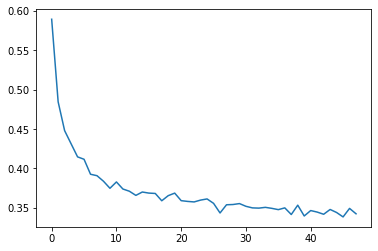

In [ ]:
# plot losses
plt.plot(clf.history['loss'])

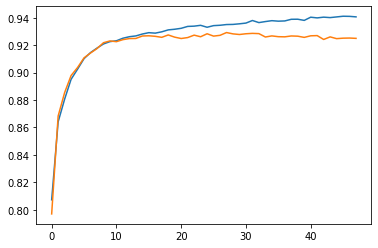

In [ ]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

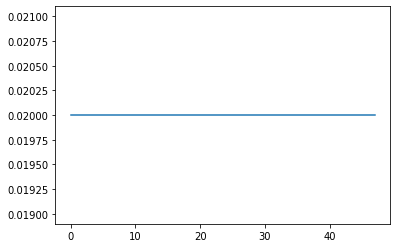

In [ ]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9291648820444631
FINAL TEST SCORE FOR census-income : 0.9229616267125913


In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [ ]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

/content/drive/MyDrive/Colab Notebooks/tabnet/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9229616267125913


In [ ]:
assert(test_auc == loaded_test_auc)

In [ ]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([0.0268236 , 0.0268236 , 0.0268236 , 0.06607823, 0.1140559 ,
       0.29189012, 0.06271217, 0.06405143, 0.05171666, 0.05171666,
       0.05171666, 0.0680075 , 0.08394577, 0.01363809])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

<ipython-input-32-cdd8a56390e0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels = features, rotation=45)


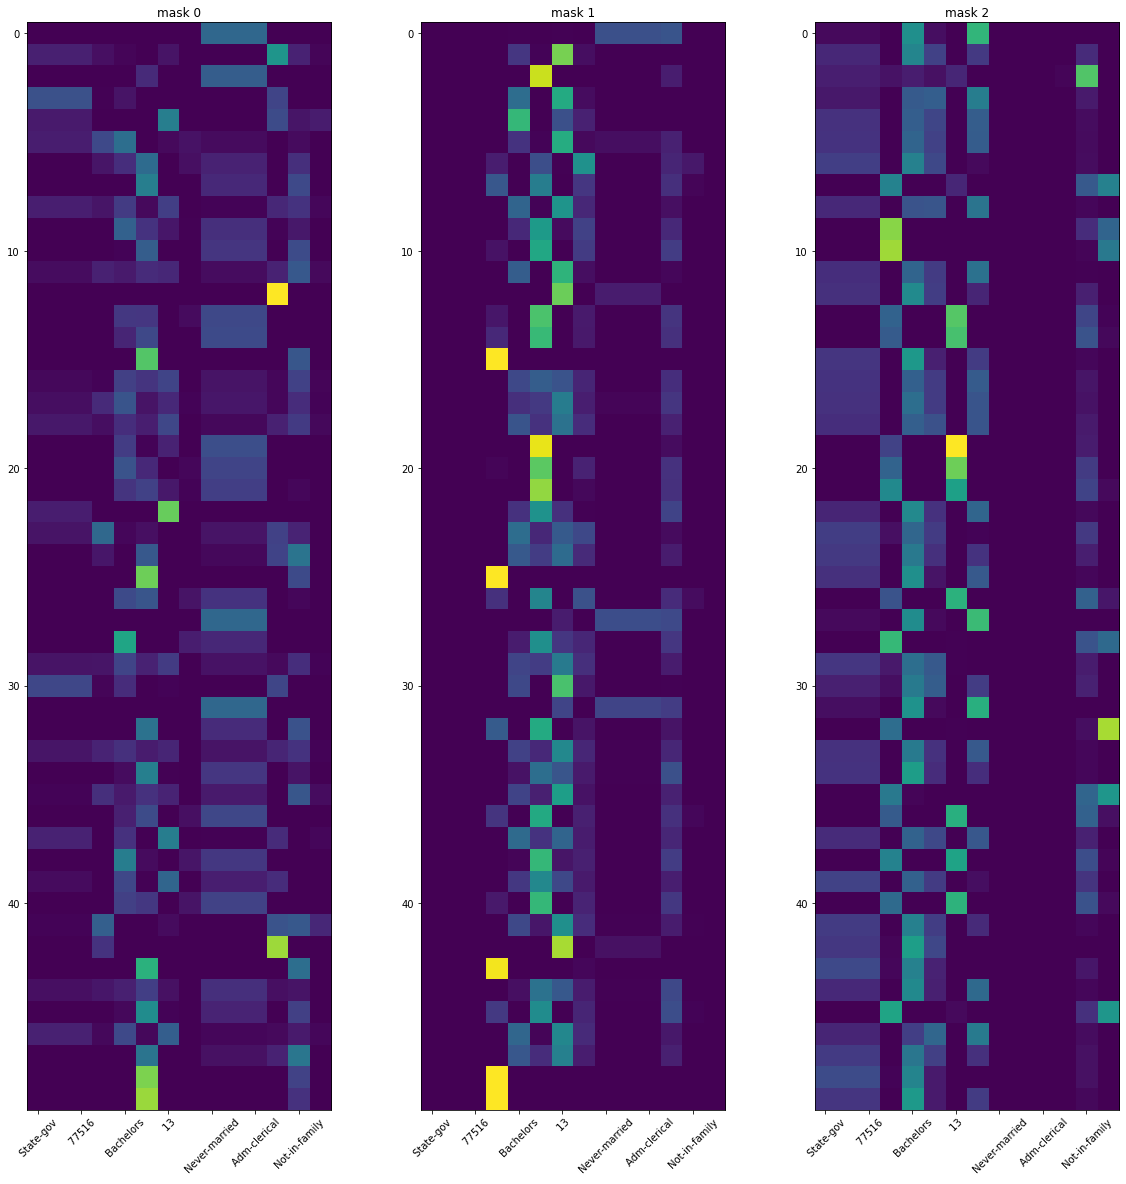

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = features, rotation=45)

# XGB

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

ValueError: ignored

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

NotFittedError: ignored